# Experimenting with possible approaches

In [1]:
!pip install -r requirements.txt

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached plotly-5.22.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached pymc-5.16.2-py3-none-any.whl.metadata (15 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
  Using cached arviz-0.19.0-py3-none-any.whl.metadata (8.9 kB)
  Using cached xarray-2024.6.0-py3-none-any.whl.metadata (11 kB)
  Using cached h5netcdf-1.3.0-py3-none-any.whl.metadata (13 kB)
  Using cached xarray_einstats-0.7.0-py3-none-any.whl.metadata (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
  Using cached etuples-0.3.9.tar.gz (30 kB)
  Preparing metadata (setup.py) ... done
  Using cached logical-unification-0.4.6.tar.gz (31 kB)
  Preparing metadata (setup.py) ... done
  Using cached miniKanren-1.0.3.tar.gz (41 kB)
  Preparing metadata (setu

## Imports

In [37]:
import numpy as np
import pandas as pd
import pymc as pm
import geopy.distance
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data compilation

In [3]:
# assumptions
# source - https://www.icaew.com/insights/viewpoints-on-the-news/2022/sept-2022/chart-of-the-week-energy-price-cap-update
GAS_PRICE_PER_KWH = 3.3
ELECTRIC_PRICE_PER_KWH = 19.0 

In [4]:
# look at the headline dataset of consumption by LSOA
main_data = pd.read_csv("data/LSOA Energy Consumption Data.csv")

In [5]:
main_data.shape

(33811, 21)

In [6]:
main_data['Lower Layer Super Output Area (LSOA) Code'].nunique()

33811

In [7]:
# Library to work with netCDF files
from netCDF4 import Dataset

file_name = "data/tas_hadukgrid_uk_60km_ann_202101-202112.nc"
file_id = Dataset(file_name)

latitude = file_id.variables["latitude"][:,:]
longitude = file_id.variables["longitude"][:,:]
temps = file_id.variables["tas"][:,:]

lats = [np.mean(x) for x in latitude]
longs = [np.mean(x) for x in longitude] 
ts = [np.mean(x) for x in temps[0]]
temp_data = pd.DataFrame({"latitude": lats,
                          "longitude": longs,
                          "temperature": ts}
                        )

temp_data = temp_data[temp_data.temperature > 0]

### Combining and generating features

In [8]:
# feature generation
main_data["pct_electric"] = main_data['Electricity Consumption (kWh)'] / main_data['Total Energy Consumption (kWh)']
main_data["coords"] = [(lat, long) for lat, long in zip(main_data.Latitude, main_data.Longitude)]

df = main_data[['Local Authority Name', 'Local Authority Code', 'MSOA Name',
       'Middle Layer Super Output Area (MSOA) Code', 'LSOA Name',
       'Lower Layer Super Output Area (LSOA) Code', 'coords',
       'pct_electric', 'Average Energy Consumption per Person (kWh)']]

df.columns = ['LA_name', 'LA', 'MSOA_ame',
       'MSOA', 'LSOA_name',
       'LSOA', 'coords',
       'pct_electric', 'energy_consumption_per_person']

In [9]:
list(zip(lats, longs))

[(49.006341737877655, -3.7734278198507476),
 (49.54449813888834, -3.792737447518625),
 (50.082569071478424, -3.812630309295943),
 (50.62055323102576, -3.8331293263161883),
 (51.15844925067594, -3.8542586753822228),
 (51.69625569571884, -3.876043874627027),
 (52.233971057493775, -3.898511876267551),
 (52.77159374677694, -3.9216911671417876),
 (53.309122086599764, -3.945611877796649),
 (53.84655430444121, -3.970305900981369),
 (54.38388852372945, -3.995807020499611),
 (54.92112275458157, -4.022151051484733),
 (55.458254883700604, -4.049375993288645),
 (55.99528266333978, -4.0775221963176405),
 (56.5322036992321, -4.106632544310854),
 (57.06901543737092, -4.136752653741774),
 (57.60571514951215, -4.167931092233809),
 (58.142299917252004, -4.200219618121363),
 (58.6787666145142, -4.233673443562959),
 (59.21511188825929, -4.26835152392834),
 (59.75133213720162, -4.304316876543453),
 (60.2874234882904, -4.34163693229389),
 (60.82338177067651, -4.380383924067725)]

In [10]:
# add temperature data
coords =  [(lat, long) for lat, long in zip(temp_data.latitude, temp_data.longitude)]
temp_dict = {co:t for co,t in zip(coords, temp_data.temperature)}

def find_closest_temp_measurement(this_point):
    return temp_dict[min(temp_dict.keys(), key=lambda x: geopy.distance.geodesic(this_point, x))]

df["temperature"] = [find_closest_temp_measurement(x) for x in df.coords]

/tmp/ipykernel_1982/1322134421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temperature"] = [find_closest_temp_measurement(x) for x in df.coords]


In [11]:
# compute energy cost
df["energy_cost"] = [ELECTRIC_PRICE_PER_KWH * x + GAS_PRICE_PER_KWH * (1-x) for x in df["pct_electric"]]

/tmp/ipykernel_1982/605917991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["energy_cost"] = [ELECTRIC_PRICE_PER_KWH * x + GAS_PRICE_PER_KWH * (1-x) for x in df["pct_electric"]]


In [12]:
# add income data
income_data = pd.read_csv("data/net_income_after_housing_costs.csv")
income_data = income_data[["MSOA code", "Net annual income after housing costs (£)"]].copy()
income_data.columns = ["MSOA", "net_income"]
df = df.merge(income_data, on="MSOA", how="left")

In [13]:
income_data

,MSOA,net_income
0,E02004297,"27,700"
1,E02004290,"28,600"
2,E02004298,"31,400"
3,E02004299,"25,000"
4,E02004291,"23,800"
...,...,...
7196,W02000362,"29,300"
7197,W02000363,"24,000"
7198,W02000364,"20,300"
7199,W02000365,"21,700"


In [14]:
df.shape

(33811, 12)

In [15]:
# add green data
voting_data = pd.read_csv("data/CBP09228_detailed_results_England_elections.csv")
voting_data["pct_green"] = voting_data["Green"] / voting_data["Total"]
voting_data["green_council"] = voting_data["pct_green"] >= 0.1
voting_data = voting_data[["ONS code", "green_council"]].copy()
voting_data.columns = ["LA", "politically_green"]
df = df.merge(voting_data, on="LA", how="left")

In [16]:
df.shape

(33811, 13)

In [17]:
# add employment status
economic_activity = pd.read_csv("data/economic_activity.csv")
economic_activity = economic_activity[["Area code", "Economically active: \nIn employment \n(including full-time students), \n2021\n(percent)"]]
economic_activity.columns = ["LA", "pct_economically_active"]
df = df.merge(economic_activity, on="LA", how="left")

In [18]:
df.shape

(33811, 14)

In [19]:
# add in home occupancy data
households = pd.read_csv("data/RM202-Household-Size-By-Number-Of-Rooms-2021-lsoa-ONS.csv")
households.rename(columns={"Lower layer Super Output Areas Code": "LSOA"}, inplace=True)
households["pct_home_occupancy"] = households["Household size (5 categories) Code"] / households["Number of rooms (Valuation Office Agency) (6 categories) Code"]
households["pct_home_occupancy_x_obs"] = households["pct_home_occupancy"] * households["Observation"]
households["home_size_x_obs"] = households["Number of rooms (Valuation Office Agency) (6 categories) Code"] * households["Observation"]
totals = households.groupby("LSOA")[["pct_home_occupancy_x_obs", "home_size_x_obs", "Observation"]].sum().reset_index()
totals["home_size"] = totals["home_size_x_obs"] / totals["Observation"]
totals["pct_home_occupancy"] = totals["pct_home_occupancy_x_obs"] / totals["Observation"]
totals = totals[["LSOA", "home_size", "pct_home_occupancy"]]
df = df.merge(totals, on="LSOA", how="left")

In [20]:
df.shape

(33811, 16)

In [21]:
# add in building type - go for pct detatched
buildings1 = pd.read_csv("data/CTSOP_3_1_2021.csv")
buildings1 = buildings1[(buildings1.geography == "LSOA") & (buildings1.band == "All")]
buildings1 = buildings1[["ecode", "bungalow_total", "flat_mais_total", "house_terraced_total",
                         "house_semi_total", "house_detached_total", "all_properties"]]
buildings1 = buildings1.replace("-","0")

# num exposed surfaces
exposed_surfaces_per_type = {
    "bungalow_total": 5,
    "flat_mais_total": 2,
    "house_terraced_total": 3,
    "house_semi_total": 4,
    "house_detached_total": 5
}

buildings1[list(exposed_surfaces_per_type.keys())] = buildings1[exposed_surfaces_per_type.keys()].astype(int)
total_exposed_surfaces = buildings1[list(exposed_surfaces_per_type.keys())].mul(exposed_surfaces_per_type).sum(axis=1)
buildings1["home_exposed_surfaces"]  = [x / int(y) for x,y in zip(total_exposed_surfaces,  buildings1["all_properties"])]
buildings1 = buildings1[["ecode", "home_exposed_surfaces"]]
buildings1.columns = ["LSOA", "home_exposed_surfaces"]

df = df.merge(buildings1, on="LSOA", how="left")

In [22]:
df.shape

(33811, 17)

In [23]:
# add in building age
buildings2 = pd.read_csv("data/CTSOP_4_1_2021.csv")
buildings2 = buildings2[(buildings2.geography == "LSOA") & (buildings2.band == "All")]
buildings2 = buildings2.replace("-","0")

build_dates = {
    'bp_pre_1900': 1900,
    'bp_1900_1918': 1910, 
    'bp_1919_1929': 1925, 
    'bp_1930_1939': 1935, 
    'bp_1945_1954': 1950,
    'bp_1955_1964': 1960, 
    'bp_1965_1972': 1969, 
    'bp_1973_1982': 1978, 
    'bp_1983_1992': 1988,
    'bp_1993_1999': 1996, 
    'bp_2000_2008': 2004, 
    'bp_2009': 2009, 
    'bp_2010': 2010, 
    'bp_2011': 2011,
    'bp_2012': 2012, 
    'bp_2013': 2013, 
    'bp_2014': 2014, 
    'bp_2015': 2015, 
    'bp_2016': 2016, 
    'bp_2017': 2017,
    'bp_2018': 2018,
    'bp_2019': 2019,
    'bp_2020': 2020,
    'bp_2021': 2021,
    'bp_2022_2023': 2021,
    'bp_unkw': 1900 # assume if unknown then likely very old
}

buildings2[list(build_dates.keys())] = buildings2[build_dates.keys()].astype(int)
build_year = buildings2[list(build_dates.keys())].mul(build_dates).sum(axis=1)
totals = buildings2[list(build_dates.keys())].sum(axis=1)
buildings2["home_age"]  = [2021-(x / y) for x,y in zip(build_year,  totals)]
buildings2 = buildings2[["ecode", "home_age"]]
buildings2.columns = ["LSOA", "home_age"]

df = df.merge(buildings2, on="LSOA", how="left")

In [24]:
df.shape

(33811, 18)

In [25]:
# write clean file
df.columns
final_columns = ['LSOA', 'temperature','energy_cost', 'net_income', 'politically_green',
       'pct_economically_active', 'home_size', 'pct_home_occupancy',
       'home_exposed_surfaces', 'home_age', 'energy_consumption_per_person']
df = df[final_columns]
# df.to_csv("compiled_data.csv")

## 2. Analysis and data viz

In [33]:
df = pd.read_csv("compiled_data.csv")
df.shape

# data cleaning
df["politically_green"] = [1 if x == True else 0 for x in df.politically_green]
df["net_income"] = [int(x.replace(",","").strip()) for x in df.net_income]

<Axes: >

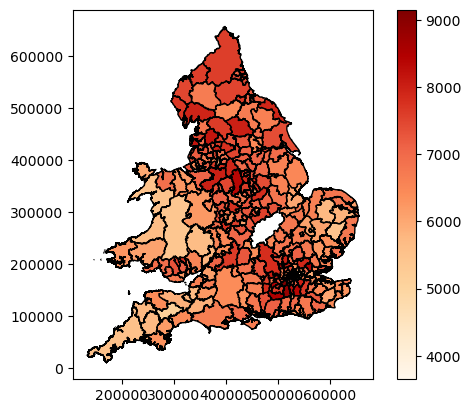

In [34]:
# plot map
las = gpd.GeoDataFrame.from_file("data/LAD_DEC_2021_UK_BFC.shp")
las.rename(columns={"LAD21CD":"LA"}, inplace=True)
df_energy = df.groupby("LA")["energy_consumption_per_person"].mean().reset_index()
las = las.merge(df_energy, on="LA", how="left")
las.plot(column="energy_consumption_per_person", cmap="OrRd", edgecolor="k", legend=True)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'temperature'),
  Text(1.5, 0, 'energy_cost'),
  Text(2.5, 0, 'net_income'),
  Text(3.5, 0, 'politically_green'),
  Text(4.5, 0, 'pct_economically_active'),
  Text(5.5, 0, 'home_size'),
  Text(6.5, 0, 'pct_home_occupancy'),
  Text(7.5, 0, 'home_exposed_surfaces'),
  Text(8.5, 0, 'home_age'),
  Text(9.5, 0, 'energy_consumption_per_person')])

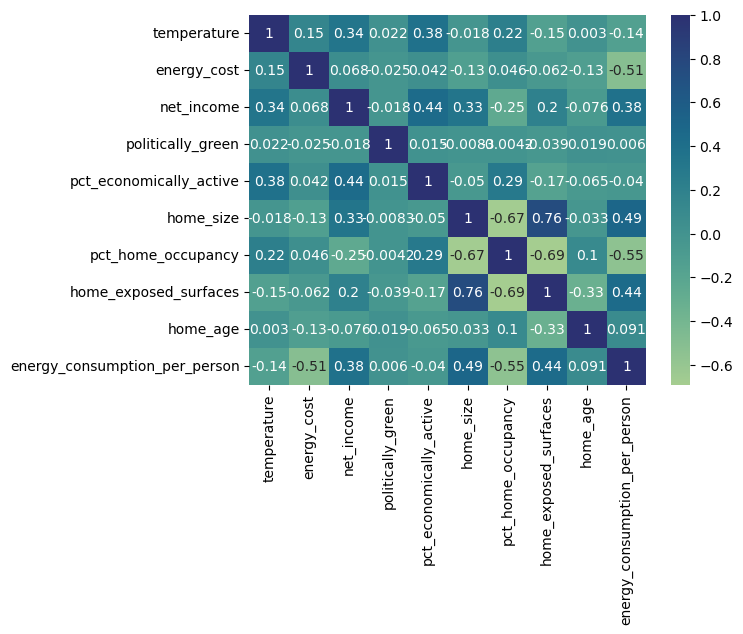

In [44]:
# correlations plot
corr_data = df.drop(columns=['LA', 'MSOA', 'LSOA'], axis=1).corr()
corr_heatmap = sns.heatmap(corr_data, cmap="crest", annot=True) 
corr_heatmap.set(xlabel="", ylabel="")
corr_heatmap.xaxis.tick_bottom()
plt.xticks(rotation=90)

array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'energy_cost'}>,
        <Axes: title={'center': 'net_income'}>],
       [<Axes: title={'center': 'politically_green'}>,
        <Axes: title={'center': 'pct_economically_active'}>,
        <Axes: title={'center': 'home_size'}>],
       [<Axes: title={'center': 'pct_home_occupancy'}>,
        <Axes: title={'center': 'home_exposed_surfaces'}>,
        <Axes: title={'center': 'home_age'}>],
       [<Axes: title={'center': 'energy_consumption_per_person'}>,
        <Axes: >, <Axes: >]], dtype=object)

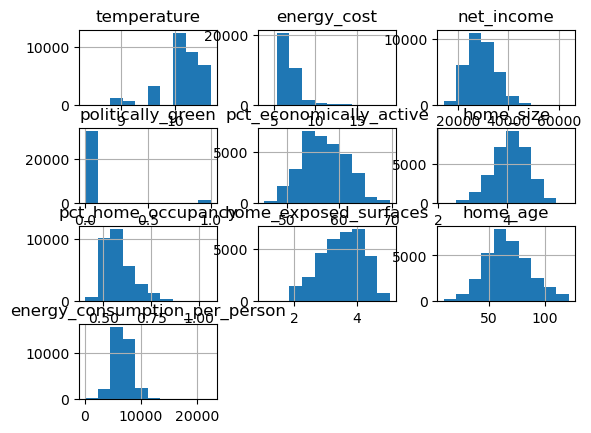

In [45]:
df.hist()

## 3. Modelling

In [28]:
# data preparation - cleaning

In [29]:
# data preparation - normalisation

In [30]:
# model

In [31]:
# inference

In [32]:
# results